In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import KBinsDiscretizer


from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import BernoulliNB, BaseEstimator, BaseNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline


import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
import plotly
import plotly.graph_objects as go

In [2]:
df = pd.read_csv("../data/Churn_Modelling.csv")
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [3]:
df.drop(columns=['CustomerId', 'RowNumber', 'Surname'], inplace=True)
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [4]:
df_train, df_validate = train_test_split(df, test_size=0.10)

# Credit Score Investigation

In [5]:
def plot_hist(df, col):
    plt.figure(figsize=(8, 5))
    plt.grid(linestyle='dashed', alpha=0.3, zorder=0)
    plt.hist(df[col], alpha=0.8, zorder=2)
    plt.title(col.capitalize())
    plt.show()

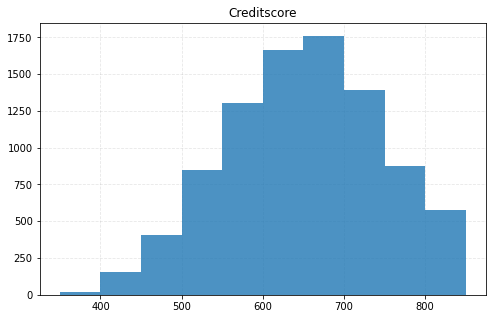

In [6]:
plot_hist(df=df_train, col='CreditScore')

In [7]:
df_train.columns

Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Exited'],
      dtype='object')

In [8]:
# let' build a feature on credit_score quantiles
# we would want to do this before we select columns


discretized_cols = ['CreditScore', 'Age', 'Tenure', 'Balance','NumOfProducts', 'EstimatedSalary']
new_cols = [col+"Bin" for col in discretized_cols]
discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal')
discretizer.fit(df_train[discretized_cols])
df_train[new_cols] = discretizer.transform(df_train[discretized_cols])
df_train.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,CreditScoreBin,AgeBin,TenureBin,BalanceBin,NumOfProductsBin,EstimatedSalaryBin
9475,616,France,Male,46,2,0.00,2,1,0,137136.46,0,1.0,4.0,1.0,0.0,1.0,3.0
8363,557,Germany,Male,57,1,120043.13,1,1,0,132370.75,1,0.0,4.0,0.0,2.0,0.0,3.0
8387,699,France,Male,44,8,158697.61,1,1,0,107181.22,0,3.0,3.0,4.0,3.0,0.0,2.0
1163,747,Germany,Female,32,5,67495.04,2,0,1,77370.37,0,4.0,1.0,2.0,0.0,1.0,1.0
594,779,Spain,Female,26,4,174318.13,2,0,1,38296.21,0,4.0,0.0,2.0,3.0,1.0,0.0


In [39]:
class FeatureSelector(BaseEstimator):

    
    def __init__( self, columns=None):
        self.columns = columns
    
    def fit( self, X, y = None ):
        return self 
    
    def transform( self, X, y = None ):
        return X[ self.columns ] 

# Constructing a pipeline

In [19]:
pipeline = Pipeline(steps=[
    ('featureSelector', FeatureSelector()),
    ('knn', KNeighborsClassifier())
])

In [11]:
X = df_train.drop(columns=['Exited'])
y = df_train['Exited']

In [ ]:
pipeline.fit(X, y)

In [36]:
X_valid = df_validate.drop(columns=['Exited'])
y_valid = df_validate['Exited']

In [ ]:
pipeline.score(X_valid, y_valid)

# GridSearch on a Pipeline

In [40]:
params = {
    'featureSelector__columns': [['Age', 'EstimatedSalary'], ['CreditScore', 'Age', 'EstimatedSalary']],
    'knn__n_neighbors': [3, 5, 8, 10],
    'knn__p': [1, 2, 3]
}

In [41]:
gs_pipelines = GridSearchCV(pipeline, param_grid=params, cv=5, n_jobs=-1, verbose=2)

In [42]:
gs_pipelines.fit(X, y)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    5.0s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('featureSelector', FeatureSelector()),
                                       ('knn', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'featureSelector__columns': [['Age',
                                                       'EstimatedSalary'],
                                                      ['CreditScore', 'Age',
                                                       'EstimatedSalary']],
                         'knn__n_neighbors': [3, 5, 8, 10],
                         'knn__p': [1, 2, 3]},
             verbose=2)

In [43]:
gs_pipelines.score(X_valid, y_valid)

0.806

In [44]:
gs_pipelines.score(X, y)

0.7981111111111111